In [7]:
class_map = {
    "협박 대화": 0,
    "갈취 대화": 1,
    "직장 내 괴롭힘 대화": 2,
    "기타 괴롭힘 대화": 3,
    "일반 대화": 4,
}
label_to_class = {v: k for k, v in class_map.items()}

In [8]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from datetime import datetime, timezone, timedelta

KST = timezone(timedelta(hours=9))
NOW = datetime.now(KST).strftime('%Y%m%d%H%M%S') # YYYYMMDDHHmmss
print(f"{NOW=}")

# Parameters
TRAIN_DATA_PATH = "data/train_with_normal_nikl.csv"
MODEL_NAME = "klue/bert-base"
SAVE_MODEL_PATH = f"models/bert_{NOW}"
MAX_LENGTH = 200
NUM_CLASSES = len(class_map)
BATCH_SIZE = 16
EPOCHS = 10

tokenizer = BertTokenizer.from_pretrained(MODEL_NAME, 
                                          max_len=MAX_LENGTH,
                                          truncation=True, 
                                          padding=True)
model = TFBertForSequenceClassification.from_pretrained(MODEL_NAME,
                                                        num_labels=NUM_CLASSES, 
                                                        from_pt=True)

NOW='20240626194825'


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from konlpy.tag import Okt
import re

okt = Okt()

def preprocess_conversation(conversation):
    conversation = conversation.replace("\n", " ")
    # 특수문자 제거
    conversation = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣0-9a-zA-Z?.!\s]", "", conversation)
    # 영어 소문자화
    conversation = conversation.lower()
    
    # 불용어 제거
    stopwords = ['은','는','이','가','을','를','에','이가','이는']
    stopword_removed = []
    for word in okt.morphs(conversation):
        if word in stopwords:
            continue
        stopword_removed.append(word)
        
    return " ".join(stopword_removed)


def tokenize(texts, labels, max_length):
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length)
    dataset = tf.data.Dataset.from_tensor_slices((
        dict(encodings),
        labels
    ))
    return dataset

train_df = pd.read_csv(TRAIN_DATA_PATH)
train_df["class_num"] = train_df["class"].map(class_map)
train_df = train_df.drop_duplicates(subset=["conversation"])
train_df["conversation"] = train_df["conversation"].apply(preprocess_conversation)

X_train, X_val, y_train, y_val = train_test_split(train_df["conversation"], train_df["class_num"], 
                                                  test_size=0.2, random_state=42, 
                                                  stratify=train_df["class_num"])

train_dataset = (tokenize(X_train.tolist(), y_train, MAX_LENGTH)
           .shuffle(len(X_train))
           .batch(BATCH_SIZE)
           .prefetch(tf.data.experimental.AUTOTUNE))

val_dataset = (tokenize(X_val.tolist(), y_val, MAX_LENGTH)
           .shuffle(len(X_val))
           .batch(BATCH_SIZE)
           .prefetch(tf.data.experimental.AUTOTUNE))

In [4]:
optimizer = Adam(learning_rate=3e-5)
loss = SparseCategoricalCrossentropy(from_logits=True)
metrics = [SparseCategoricalAccuracy("accuracy")]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

histories = []

# Train the model
for i in range(EPOCHS):
    history = model.fit(train_dataset,
                        epochs=1,
                        validation_data=val_dataset)
    histories.append(history)
    
    # ModelCheckpoint callback으로 처리하려고 했는데 오류가 나서, epoch 마다 저장
    model.save_pretrained(f"{SAVE_MODEL_PATH}/{i+1}_{history.history['val_loss'][0]:.4f}")

243/243 [==============================] - 172s 707ms/step - loss: 0.0388 - accuracy: 0.9889 - val_loss: 0.4853 - val_accuracy: 0.9010


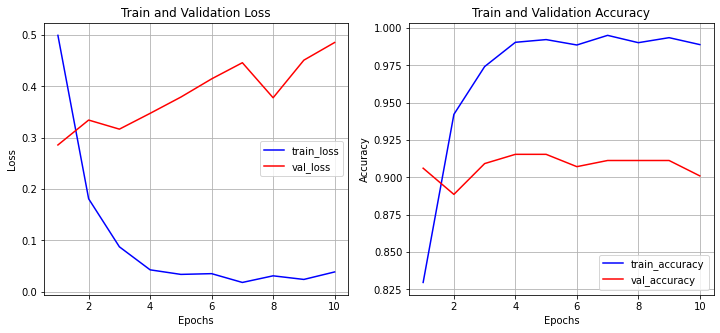

In [6]:
import matplotlib.pyplot as plt

loss = [h.history["loss"][0] for h in histories]
accuracy = [h.history["accuracy"][0] for h in histories]

val_loss = [h.history["val_loss"][0] for h in histories]
val_accuracy = [h.history["val_accuracy"][0] for h in histories]

epochs = range(1, len(loss) + 1)

fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color='blue', label='train_loss')
ax1.plot(epochs, val_loss, color='red', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()


ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, color='blue', label='train_accuracy')
ax2.plot(epochs, val_accuracy, color='red', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

## Evaluate

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

plt.rc("font", family="NanumBarunGothic")

def predict(model, X):
    start_index = 0
    end_index = start_index + BATCH_SIZE 
    X_batch = X[start_index:end_index]

    predictions = []
    while len(X_batch) > 0:
        X_batch_seq = tokenizer(X_batch.tolist(), truncation=True, padding=True, 
                                max_length=MAX_LENGTH, 
                                return_tensors="tf")
        batch_predictions_proba = model(X_batch_seq)
        batch_prediction = np.argmax(batch_predictions_proba.logits, axis=1)
        predictions += batch_prediction.tolist()
        
        start_index += BATCH_SIZE
        end_index += BATCH_SIZE
        X_batch = X[start_index:end_index]

    return predictions

def plot_confusion_matrix(y_true, y_pred): 
    cm = confusion_matrix(y_true, y_pred, normalize="true")
    fig , ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_map.keys())
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False) 
    plt.title("Normalized confusion matrix")
    plt.show() 


Some layers from the model checkpoint at models/bert_20240626190114/1_0.2859 were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at models/bert_20240626190114/1_0.2859.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


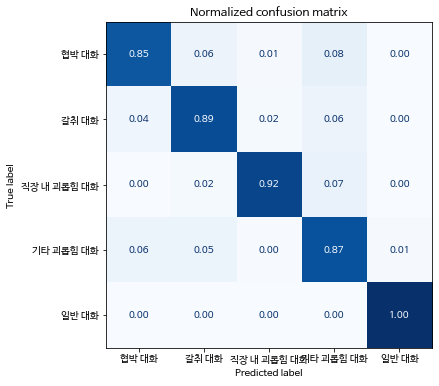

In [20]:
BEST_MODEL_PATH = "models/bert_20240626190114/1_0.2859" # validation metric을 확인 후 결정
model = TFBertForSequenceClassification.from_pretrained(BEST_MODEL_PATH)
predictions = predict(model, X_val)
plot_confusion_matrix(y_val, predictions)

## Submission

In [21]:
import json

def load_test_df():
    with open("data/test.json") as file:
        test_json = json.load(file)
    
    file_names = []
    conversations = []
    for file_name in test_json:
        conversation = test_json[file_name]["text"]

        file_names.append(file_name)
        conversations.append(conversation)
        
    return pd.DataFrame({"file_name": file_names, "conversation": conversations})
    
test_df = load_test_df()
test_df

,file_name,conversation
0,t_000,아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나...
1,t_001,우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때? 네? 제가요? ...
2,t_002,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...
3,t_003,이거 들어바 와 이 노래 진짜 좋다 그치 요즘 이 것만 들어 진짜 너무 좋다 내가 ...
4,t_004,아무튼 앞으로 니가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도...
...,...,...
495,t_495,미나씨 휴가 결제 올리기 전에 저랑 상의하라고 말한거 기억해요? 네 합니다. 보고서...
496,t_496,교수님 제 논문에 제 이름이 없나요? 아 무슨 논문말이야? 지난 번 냈던 논문이...
497,t_497,야 너 네 저요? 그래 너 왜요 돈좀 줘봐 돈 없어요 돈이 왜 없어 지갑은 폼이...
498,t_498,야 너 빨리 안 뛰어와? 너 이 환자 제대로 봤어 안 봤어 어제 저녁부터 계속 보다...


In [22]:
test_df["conversation"] = test_df["conversation"].apply(preprocess_conversation)
X_test = test_df["conversation"]
X_test = tokenizer(X_test.tolist(), truncation=True, padding=True, max_length=MAX_LENGTH, return_tensors="tf")

In [23]:
import numpy as np

predictions_proba = model(X_test)
predictions = np.argmax(predictions_proba.logits, axis=1)
test_df["class"] = predictions
test_df["class_str"] = test_df["class"].apply(lambda x: label_to_class[x])
test_df

,file_name,conversation,class,class_str
0,t_000,아가씨 담배 한 갑주소 네 4500원 입니다 어 네 지갑 어디 갔지 에이 버스 에서...,1,갈취 대화
1,t_001,우리 팀 에서 다른 팀 으로 갈 사람 없나 ? 그럼 영 지씨 가는건 어때 ? 네 ?...,2,직장 내 괴롭힘 대화
2,t_002,너 오늘 그게 뭐 야 네 제 뭘 잘 못 했나요 .? 제대로 좀 하지 네 똑바로 좀 ...,2,직장 내 괴롭힘 대화
3,t_003,거 들어 바 와 노래 진짜 좋다 그치 요즘 것 만 들어 진짜 너무 좋다 내 요즘 듣...,3,기타 괴롭힘 대화
4,t_004,아무튼 앞 으로 니 내 와이파이 야 . . 응 와이파이 온 . 켰어 . 반말 ? 주...,3,기타 괴롭힘 대화
...,...,...,...,...
495,t_495,미나 씨 휴가 결제 올 리기 전 저 랑 상의 하 라고 말 한 거 기억 해요 ? 네 ...,2,직장 내 괴롭힘 대화
496,t_496,교수 님 제 논문 제 이름 없나요 ? 아 무슨 논문 말 이야 ? 지난 번 냈던 논문...,2,직장 내 괴롭힘 대화
497,t_497,야 너 네 저 요 ? 그래 너 왜 요 돈좀 줘 봐 돈 없어요 돈 왜 없어 지갑 폼 ...,1,갈취 대화
498,t_498,야 너 빨리 안 뛰어와 ? 너 환자 제대로 봤어 안 봤어 어제 저녁 부터 계속 보다...,2,직장 내 괴롭힘 대화


In [24]:
print(f"submission file: submissions/bert_finetuning_{NOW}.csv")
test_df[["file_name", "class"]].to_csv(f"submissions/bert_finetuning_{NOW}.csv", index=False)
pd.read_csv(f"submissions/bert_finetuning_{NOW}.csv")

submission file: submissions/bert_finetuning_20240626194825.csv


,file_name,class
0,t_000,1
1,t_001,2
2,t_002,2
3,t_003,3
4,t_004,3
...,...,...
495,t_495,2
496,t_496,2
497,t_497,1
498,t_498,2


### Test score: 0.738